<a href="https://colab.research.google.com/github/ghazalna/Credit_Card_Transactions_Fraud_Detection/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detection of Fraudulent Transactions in Credit Card Data Using Transformers**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add
from tensorflow.keras.layers import Input, Embedding , GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l2


In [2]:
data = pd.read_csv('/content/creditcard 2.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166510 entries, 0 to 166509
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    166510 non-null  float64
 1   V1      166510 non-null  float64
 2   V2      166510 non-null  float64
 3   V3      166510 non-null  float64
 4   V4      166510 non-null  float64
 5   V5      166510 non-null  float64
 6   V6      166510 non-null  float64
 7   V7      166510 non-null  float64
 8   V8      166509 non-null  float64
 9   V9      166509 non-null  float64
 10  V10     166509 non-null  float64
 11  V11     166509 non-null  float64
 12  V12     166509 non-null  float64
 13  V13     166509 non-null  float64
 14  V14     166509 non-null  float64
 15  V15     166509 non-null  float64
 16  V16     166509 non-null  float64
 17  V17     166509 non-null  float64
 18  V18     166509 non-null  float64
 19  V19     166509 non-null  float64
 20  V20     166509 non-null  float64
 21  V21     16

In [5]:
# 0-----> Normal Transactions
# 1-----> Fraudulent Transactions

counts = data['Class'].value_counts()
print(counts)

Class
0.0    166151
1.0       358
Name: count, dtype: int64


# **Data Preprocessing**

In [6]:
#Separate features and labels

X = data.drop('Class', axis=1)
y = data['Class']

# **Normalize data**

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
#Reshape data to include sequence length dimension

#X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))


# **Split Data**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size=0.2,random_state=42)

# **Build The Model**

In [10]:
#Define hyperparameters

maxlen = X_train.shape[1]  #maxlen: Maximum sequence length.
vocab_size = maxlen        #vocab_size: Number of unique tokens.
embed_dim = 128            #embed_dim: Size of embedding vectors.
num_heads = 16             #num_heads: Number of attention heads.
ff_dim = 256               #ff_dim: Feed-forward layer dimension.
dropout_rate = 0.1         #dropout_rate: Rate for dropout regularization.

In [11]:
#Function to create positional encoding

def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [12]:
 #Function to create a transformer block

def transformer_block(inputs, embed_dim, num_heads, ff_dim, rate=0.1):
  attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
  attn_output = Dropout(rate)(attn_output)
  out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

  ffn_output = Dense(ff_dim, activation='relu')(out1)
  ffn_output = Dense(embed_dim)(ffn_output)
  ffn_output = Dropout(rate)(ffn_output)
  return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)


In [13]:
#Function to build the model

def build_model(vocab_size, maxlen, embed_dim, num_heads, ff_dim):
  inputs = Input(shape=(maxlen,))
  embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
  pos_encoding = positional_encoding(maxlen, embed_dim)
  x = embedding_layer + pos_encoding

  x = transformer_block(x, embed_dim, num_heads, ff_dim)
  x = GlobalAveragePooling1D()(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  outputs = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy",
                metrics = [Precision(), Recall()])
  return model

In [14]:
model = build_model(vocab_size, maxlen, embed_dim, num_heads, ff_dim)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 30, 128)        │          3,840 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 30, 128)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 30, 128)        │      1,054,848 │ add[0][0], add[0][0]   │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 30, 128)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 30, 128)        │              0 │ add[0][0],             │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 30, 128)        │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 30, 256)        │         33,024 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 30, 128)        │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 30, 128)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 30, 128)        │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 30, 128)        │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ layer_normalization_1… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)      

 Total params: 1,133,441 (4.32 MB)

 Trainable params: 1,133,441 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

# **Train The Model**

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [16]:
history = model.fit(
    X_train[..., np.newaxis],
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
    #,class_weight=class_weight_dict
)

Epoch 1/50
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.0152 - precision: 0.2241 - recall: 0.0772 - val_loss: 0.0042 - val_precision: 0.7857 - val_recall: 0.7213
Epoch 2/50
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0053 - precision: 0.7727 - recall: 0.7173 - val_loss: 0.0035 - val_precision: 0.8000 - val_recall: 0.7869
Epoch 3/50
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.0052 - precision: 0.7614 - recall: 0.7149 - val_loss: 0.0053 - val_precision: 0.8649 - val_recall: 0.5246
Epoch 4/50
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0051 - precision: 0.7590 - recall: 0.7171 - val_loss: 0.0062 - val_precision: 0.8788 - val_recall: 0.4754
Epoch 5/50
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0053 - precision: 0.7956 - recall: 0.6645 - val_loss: 0.0037 - val_precision: 0.7778 - val_recall: 0.9180
Epoch 6/50
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.0052 - precision: 0.8653 - recall: 0.7500 - val_loss: 0.0035 - val_precision: 0.

# **Evaluate the model**

In [17]:
y_pred = model.predict(X_test).flatten()
threshold = 0.5

y_pred_labels = (y_pred > 0.5).astype(int)


1041/1041 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [24]:
min_length = min(len(y_test), len(y_pred_labels), len(y_pred))
y_test = y_test[:min_length]
y_pred_labels = y_pred_labels[:min_length]
y_pred = y_pred[:min_length]


In [25]:
print("Length of y_test after trimming:", len(y_test))
print("Length of y_pred_labels after trimming:", len(y_pred_labels))
print("Length of y_pred after trimming:", len(y_pred))


Length of y_test after trimming: 33301
Length of y_pred_labels after trimming: 33301
Length of y_pred after trimming: 33301


Precision: 0.86
Recall: 0.81
F1 Score: 0.84
ROC AUC Score: 0.98


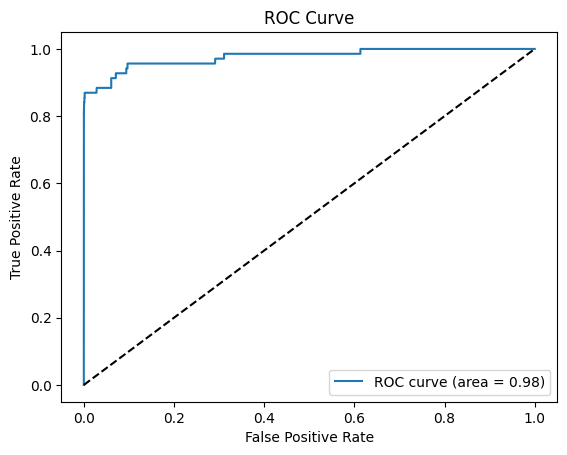

In [27]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Recalculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_labels, average='binary')

# Recalculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# **Metrics**

In [28]:
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

Precision: 0.86
Recall: 0.81
F1 Score: 0.84
ROC AUC: 0.98
